# Классификация изображений

Данный код разрабатывался в notebook Google Colaboratory

## Подготовка модели



Импортирование библиотек

In [ ]:
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.onnx
import torch.optim as optim
import warnings

from IPython.display import display, HTML
from PIL import Image
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision import models, transforms
from tqdm import tqdm
from typing import List

Загрузка данных для тренировки и проверки

In [ ]:
DIR_TRAIN = "/content/Classification-of-construction-equipment-objects/train/"
DIR_TEST = "/content/Classification-of-construction-equipment-objects/test/"

PATH_TRAIN = DIR_TRAIN + "train.csv"
PATH_TEST = DIR_TEST + "test.csv"

Классы, формирующие последовательность изображений с их меткой и названием файла. Первый класс для тренировки и проверки, второй для тестирования

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label).long(), image_name

    def __len__(self):
        return len(self.data_df)

class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']

        image = cv2.imread(DIR_TEST + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.data_df)

Класс модели классификации. Для классификации используется resnet152, для обучения алгоритм Adam

In [ ]:
class ClassificationImage:
    def __init__(self):
        """Инициализация модели и её параметров
        Parameters
        ----------
        None - ничего не принимает

        Returns
        -------
        None - ничего не возвращает

        """

        print("Обучающей выборки ", len(os.listdir(DIR_TRAIN)))
        print("Тестовой выборки ", len(os.listdir(DIR_TEST)))

        self.set_seed()

        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            # transforms.RandomResizedCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        self.valid_transform = transforms.Compose([
            # transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        self.batch_train_size = 5     # размер батча тренировки
        self.batch_valid_size = 5     # размер батча проверки
        self.batch_test_size = 5      # размер батча теста
        self.num_workers = 8          # количество процессов для загрузки данных
        self.scheduler_step_size = 1  # период уменьшения скорости обучения
        self.optimizer_lr = 0.01      # скорость обучения алгоритма Adam
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.data_df = pd.read_csv(PATH_TRAIN)

        self.train_df, self.valid_df = train_test_split(self.data_df, test_size=0.2)
        train_dataset = ImageDataset(self.train_df, self.train_transform)
        valid_dataset = ImageDataset(self.valid_df, self.valid_transform)

        self.train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_train_size, shuffle=False, num_workers=self.num_workers)
        self.valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.batch_valid_size, shuffle=False, num_workers=self.num_workers)

        self.dict_acc_for_batch = {"train": {}, "valid": {}}
        self.dict_loss_for_batch = {"train": {}, "valid": {}}


    def set_seed(self, seed: int = 0) -> None:
        """Фиксирует зерно датчика случайных чисел.
        Parameters
        ----------
        seed: int
            число для датчика

        Returns
        -------
        None - ничего не возвращает

        """
        os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
        warnings.simplefilter('ignore')
        gc.collect()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)


    def plot_history(self, train_history: List[float], val_history: List[float], title: str = 'Потери'):
        """График верности (accuracy) и потери (loss)
        Parameters
        ----------
        train_history: List[float]
            список данных результатов трениовки
        val_history: List[float]
            список данных результатов проверки
        title: str
            название графика

        Returns
        -------
        None - ничего не возвращает

        """

        plt.figure()
        plt.title('{}'.format(title))

        plt.plot(train_history, label='Тренировка', zorder=1)
        plt.plot(val_history, label='Проверка', zorder=1)

        plt.xlabel('Эпохи')
        plt.grid()
        plt.show()


    def watch_dataframe(self, data: pd.DataFrame, show_error: bool = False):
        """Удобный просмотр таблиц DataFrame
        Parameters
        ----------
        data: pd.DataFrame
            таблица с результатамитренировки или проверки
        show_error: bool
            флаг, при котором показываются те записи, в которых предсказанный класс не совпадает с истинным

        Returns
        -------
        None - ничего не возвращает

        """

        data_temp = data
        if show_error:
            data_temp = data[data["Предсказанный.\\nкласс"] != data["Истинный класс"]]
        display(HTML(data_temp.to_html().replace("\\n","<br>")))


    def watch_img(self):
        """Просмотр изображений
        Parameters
        ----------
        None - ничего не принимает

        Returns
        -------
        None - ничего не возвращает

        """

        ax = sns.countplot(x="class", data=self.data_df)
        ax.set_xlabel("Класс объекта")
        ax.set_ylabel("Количество")

        fig, axs = plt.subplots(2, 4, figsize=(16, 8))

        for i, name in zip(range(4), self.data_df[self.data_df['class'] == 1].sample(4, random_state=42)['ID_img']):
            img = plt.imread(DIR_TRAIN + f"{name}")
            axs[i // 2, (i % 2)].imshow(img)
            axs[i // 2, (i % 2)].axis('off')

        for i, name in zip(range(4), self.data_df[self.data_df['class'] == 0].sample(4, random_state=42)['ID_img']):
            img = plt.imread(DIR_TRAIN + f"{name}")
            axs[i // 2, (i % 2) + 2].imshow(img)
            axs[i // 2, (i % 2) + 2].axis('off')

        fig.tight_layout()
        fig.subplots_adjust(top=0.88)

    def crossvalid(self, n_splits: int = 4, num_epoch: int = 10):
        """Кроссвалидация
        Parameters
        ----------
        n_splits: int
            количество разбиений последовательности данных
        num_epoch: int
            количество эпох

        Returns
        -------
        Tuple[List[float], List[float], List[float], List[float], pd.DataFrame, pd.DataFrame]
            потери на тренировке,
            точность на тренировке,
            потери на проверке,
            точность на проверке,
            таблица точностей предсказанного класса и истинного на тренировке,
            таблица точностей предсказанного класса и истинного на проверке
        """

        train_loss_log, val_loss_log = [], []
        train_acc_log, val_acc_log = [], []
        train_loss_log_for_batch, val_loss_log_for_batch = [], []
        train_acc_log_for_batch, val_acc_log_for_batch = [], []
        train_predicts, valid_predicts, train_classes, valid_classes = [], [], [], []
        train_recall, val_recall = [], []
        metrics_file_train, metrics_file_valid = pd.DataFrame(), pd.DataFrame()

        self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Linear(2048, 8)
        self.model = self.model.to(self.device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.optimizer_lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=self.scheduler_step_size)
        kf = KFold(n_splits)
        cros_dataset = ImageDataset(self.data_df, self.train_transform)

        for _fold, (train_index, valid_index) in tqdm(enumerate(kf.split(cros_dataset)), total=n_splits):
            train_dataset = Subset(cros_dataset, train_index)
            train_dataloader = DataLoader(train_dataset, self.batch_train_size, shuffle=False)
            valid_dataset = Subset(cros_dataset, valid_index)
            valid_dataloader = DataLoader(valid_dataset, self.batch_valid_size, shuffle=False)

            for epoch in range(num_epoch):
                self.model.train()
                train_loss = 0.
                train_size = 0
                train_pred = 0.
                valid_predicts.clear()
                train_predicts.clear()
                train_classes.clear()
                valid_classes.clear()

                scheduler.step()
                for imgs, labels, image_name in train_dataloader:
                    optimizer.zero_grad()
                    imgs = imgs.to(self.device)
                    labels = labels.to(self.device)
                    pred_train = self.model(imgs)

                    loss = criterion(pred_train, labels)
                    loss.backward()

                    train_size += pred_train.size(0)
                    train_loss += loss.item()
                    train_loss_log_for_batch.append(loss.data / pred_train.size(0))
                    train_pred += (pred_train.argmax(1) == labels).sum()
                    train_acc_log_for_batch.append(train_pred / pred_train.size(0))
                    optimizer.step()

                    for i in range(pred_train.size(0)):
                        metrics_file_temp = pd.DataFrame({"№ эпохи":[epoch],
                                                          "Файл":[image_name[i]],
                                                          "Предсказанный.\\nкласс":[pred_train.argmax(1)[i].cpu().item()],
                                                          "Верность(accuracy)\\nпредс. класса":[pred_train.max(1).values[i].cpu().detach().numpy()],
                                                          "Истинный класс":[labels[i].cpu().item()],
                                                          "Верность(accuracy)\\nистин. класса":[pred_train[i][labels[i]].cpu().detach().numpy()]})
                        metrics_file_train = metrics_file_train.append(metrics_file_temp, ignore_index = True)
                        metrics_file_train.name = 'Тренировка'
                    pred_train_numpy = pred_train.cpu().detach().numpy()
                    for class_obj in pred_train_numpy:
                        index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
                        train_predicts.append(index)
                    train_classes.extend(labels.cpu().numpy().tolist())

                train_recall.append(recall_score(train_classes, train_predicts, average = "macro"))

                train_loss_log.append(train_loss / train_size)
                train_acc_log.append(train_pred.item() / train_size)

                self.dict_loss_for_batch["train"].update({epoch: train_loss_log_for_batch[:]})
                self.dict_acc_for_batch["train"].update({epoch: train_acc_log_for_batch[:]})

                val_loss = 0.
                val_size = 0
                val_pred = 0.
                self.model.eval()

                with torch.no_grad():
                    for imgs, labels, image_name in valid_dataloader:
                        imgs = imgs.to(self.device)
                        labels = labels.to(self.device)
                        pred_valid = self.model(imgs)
                        loss = criterion(pred_valid, labels)

                        val_size += pred_valid.size(0)
                        val_loss += loss.item()
                        val_loss_log_for_batch.append(loss.data / pred_valid.size(0))
                        val_pred += (pred_valid.argmax(1) == labels).sum()
                        val_acc_log_for_batch.append(val_pred / pred_valid.size(0))

                        for i in range(pred_valid.size(0)):
                            metrics_file_temp = pd.DataFrame({"№ эпохи":[epoch],
                                                              "Файл":[image_name[i]],
                                                              "Предсказанный.\\nкласс":[pred_valid.argmax(1)[i].cpu().item()],
                                                              "Верность(accuracy)\\nпредс. класса":[pred_valid.max(1).values[i].cpu().detach().numpy()],
                                                              "Истинный класс":[labels[i].cpu().item()],
                                                              "Верность(accuracy)\\nистин. класса":[pred_valid[i][labels[i]].cpu().detach().numpy()]})
                            metrics_file_valid = metrics_file_valid.append(metrics_file_temp, ignore_index = True)
                            metrics_file_valid.name = 'Проверка'
                        pred_valid_numpy = pred_valid.cpu().detach().numpy()
                        for class_obj in pred_valid_numpy:
                            index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
                            valid_predicts.append(index)
                        valid_classes.extend(labels.cpu().numpy().tolist())

                val_recall.append(recall_score(valid_classes, valid_predicts, average = "macro"))

                val_loss_log.append(val_loss / val_size)
                val_acc_log.append(val_pred.item() / val_size)

                self.dict_loss_for_batch["valid"].update({epoch: val_loss_log_for_batch[:]})
                self.dict_acc_for_batch["valid"].update({epoch: val_acc_log_for_batch[:]})


        log_loss_acc = pd.DataFrame({"Верность(accuracy)\\n(min/max)": [f"{min(train_acc_log):.3f}/{max(train_acc_log):.3f}", f"{min(val_acc_log):.3f}/{max(val_acc_log):.3f}"],
                                     "Полнота(recall)\\n(min/max)": [f"{min(train_recall):.3f}/{max(train_recall):.3f}", f"{min(val_recall):.3f}/{max(val_recall):.3f}"],
                                     "Потери (loss)(min/max)": [f"{min(train_loss_log):.3f}/{max(train_loss_log):.3f}", f"{min(val_loss_log):.3f}/{max(val_loss_log):.3f}"]
                                    }, index=["Тренировка","Проверка"])
        self.watch_dataframe(log_loss_acc)

        return train_loss_log, train_acc_log, val_loss_log, val_acc_log, metrics_file_train, metrics_file_valid

    def train(self, num_epoch: int = 10):
        """Обычная тренировка модели
        Parameters
        ----------
        num_epoch: int
            количество эпох

        Returns
        -------
        Tuple[List[float], List[float], List[float], List[float], pd.DataFrame, pd.DataFrame]
            потери на тренировке,
            точность на тренировке,
            потери на проверке,
            точность на проверке,
            таблица точностей предсказанного класса и истинного на тренировке,
            таблица точностей предсказанного класса и истинного на проверке
        """
        train_loss_log, val_loss_log = [], []
        train_acc_log, val_acc_log = [], []
        train_loss_log_for_batch, val_loss_log_for_batch = [], []
        train_acc_log_for_batch, val_acc_log_for_batch = [], []
        valid_predicts, train_predicts = [], []
        train_recall, val_recall = [], []
        metrics_file_train, metrics_file_valid = pd.DataFrame(), pd.DataFrame()

        self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Linear(2048, 8)
        self.model = self.model.to(self.device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.optimizer_lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=self.scheduler_step_size)

        for epoch in tqdm(range(num_epoch)):
            self.model.train()
            train_loss = 0.
            train_size = 0
            train_pred = 0.
            valid_predicts.clear()
            train_predicts.clear()

            scheduler.step()
            for imgs, labels, image_name in self.train_loader:
                optimizer.zero_grad()

                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                pred_train = self.model(imgs)
                loss = criterion(pred_train, labels)
                loss.backward()

                train_size += pred_train.size(0)
                train_loss += loss.item()
                train_loss_log_for_batch.append(loss.data / pred_train.size(0))
                train_pred += (pred_train.argmax(1) == labels).sum()
                train_acc_log_for_batch.append(train_pred / pred_train.size(0))
                optimizer.step()

                for i in range(pred_train.size(0)):
                    metrics_file_temp = pd.DataFrame({"№ эпохи":[epoch],
                                                      "Файл":[image_name[i]],
                                                      "Предсказанный.\\nкласс":[pred_train.argmax(1)[i].cpu().item()],
                                                      "Верность(accuracy)\\nпредс. класса":[pred_train.max(1).values[i].cpu().detach().numpy()],
                                                      "Истинный класс":[labels[i].cpu().item()],
                                                      "Верность(accuracy)\\nистин. класса":[pred_train[i][labels[i]].cpu().detach().numpy()]})
                    metrics_file_train = metrics_file_train.append(metrics_file_temp, ignore_index = True)
                    metrics_file_train.name = 'Тренировка'
                pred_train_numpy = pred_train.cpu().detach().numpy()
                for class_obj in pred_train_numpy:
                    index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
                    train_predicts.append(index)

            train_recall.append(recall_score(self.train_df['class'], train_predicts, average = "macro"))

            train_loss_log.append(train_loss / train_size)
            train_acc_log.append(train_pred.item() / train_size)

            self.dict_loss_for_batch["train"].update({epoch: train_loss_log_for_batch[:]})
            self.dict_acc_for_batch["train"].update({epoch: train_acc_log_for_batch[:]})

            val_loss = 0.
            val_size = 0
            val_pred = 0.
            self.model.eval()

            with torch.no_grad():
                for imgs, labels, image_name in self.valid_loader:
                    imgs = imgs.to(self.device)
                    labels = labels.to(self.device)
                    pred_valid = self.model(imgs)
                    loss = criterion(pred_valid, labels)

                    val_size += pred_valid.size(0)
                    val_loss += loss.item()
                    val_loss_log_for_batch.append(loss.data / pred_valid.size(0))
                    val_pred += (pred_valid.argmax(1) == labels).sum()
                    val_acc_log_for_batch.append(val_pred / pred_valid.size(0))

                    for i in range(pred_valid.size(0)):
                        metrics_file_temp = pd.DataFrame({"№ эпохи":[epoch],
                                                          "Файл":[image_name[i]],
                                                          "Предсказанный.\\nкласс":[pred_valid.argmax(1)[i].cpu().item()],
                                                          "Верность(accuracy)\\nпредс. класса":[pred_valid.max(1).values[i].cpu().detach().numpy()],
                                                          "Истинный класс":[labels[i].cpu().item()],
                                                          "Верность(accuracy)\\nистин. класса":[pred_valid[i][labels[i]].cpu().detach().numpy()]})
                        metrics_file_valid = metrics_file_valid.append(metrics_file_temp, ignore_index = True)
                        metrics_file_valid.loc[len(metrics_file_valid.index)] = [epoch, image_name[i], pred_valid.argmax(1)[i].cpu().item(), pred_valid.max(1).values[i].cpu().detach().numpy(), labels[i].cpu().item(), pred_valid[i][labels[i]].cpu().detach().numpy()]
                        metrics_file_valid.name = 'Проверка'
                    pred_valid_numpy = pred_valid.cpu().detach().numpy()
                    for class_obj in pred_valid_numpy:
                        index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
                        valid_predicts.append(index)

            val_recall.append(recall_score(self.valid_df['class'], valid_predicts, average = "macro"))

            val_loss_log.append(val_loss / val_size)
            val_acc_log.append(val_pred.item() / val_size)

            self.dict_loss_for_batch["valid"].update({epoch: val_loss_log_for_batch[:]})
            self.dict_acc_for_batch["valid"].update({epoch: val_acc_log_for_batch[:]})

        log_loss_acc = pd.DataFrame({"Верность(accuracy)\\n(min/max)": [f"{min(train_acc_log):.3f}/{max(train_acc_log):.3f}", f"{min(val_acc_log):.3f}/{max(val_acc_log):.3f}"],
                                     "Полнота(recall)\\n(min/max)": [f"{min(train_recall):.3f}/{max(train_recall):.3f}", f"{min(val_recall):.3f}/{max(val_recall):.3f}"],
                                     "Потери (loss)(min/max)": [f"{min(train_loss_log):.3f}/{max(train_loss_log):.3f}", f"{min(val_loss_log):.3f}/{max(val_loss_log):.3f}"]
                                    }, index=["Тренировка","Проверка"])
        self.watch_dataframe(log_loss_acc)

        return train_loss_log, train_acc_log, val_loss_log, val_acc_log, metrics_file_train, metrics_file_valid

    def visual_filters(self):
        """Визуализация фильтров сверточного слоя
        Parameters
        ----------
        None - ничего не принимает

        Returns
        -------
        None - ничего не возвращает

        """

        model_weights = []
        num_layer = 0

        model_children = list(self.model.cpu().children())

        for i in range(len(model_children)):
            if type(model_children[i]) == nn.Conv2d:
                model_weights.append(model_children[i].weight)
            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            model_weights.append(child.weight)

        plt.figure(figsize=(16, 16))
        # for num_layer in range(len(model_weights)):
        for i, filter in enumerate(model_weights[num_layer]):
            if i == 16 or filter.shape[-1] == 1:
                break
            plt.subplot(16, 16, i+1)
            plt.imshow(filter[0, :, :].detach(), cmap='gray')
            plt.axis('off')
        plt.show()

    def visual_maps(self):
        """Визуализация карт объектов
        Parameters
        ----------
        None - ничего не принимает

        Returns
        -------
        None - ничего не возвращает

        """

        img = cv2.imread(f"{DIR_TEST}/0.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((512, 512)),
                                        transforms.ToTensor()])
        img = np.array(img)
        img = transform(img)
        img = img.unsqueeze(0)

        conv_layers = []
        num_layer = 0
        model_children = list(self.model.cpu().children())

        for i in range(len(model_children)):
            if type(model_children[i]) == nn.Conv2d:
                conv_layers.append(model_children[i])
            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            conv_layers.append(child)

        results = [conv_layers[0](img)]
        for i in range(1, len(conv_layers)):
            results.append(conv_layers[i](results[-1]))
        outputs = results

        # for num_layer in range(len(outputs)):
        plt.figure(figsize=(15, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        for i, filter in enumerate(layer_viz):
            if i == 64:
                break
            plt.subplot(7, 10, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        plt.show()
        plt.close()

    def evaluation_model(self):
        """Результаты на тестах
        Parameters
        ----------
        None - ничего не принимает

        Returns
        -------
        None - ничего не возвращает

        """

        predicts = []
        self.model = self.model.to(self.device)

        self.test_df = pd.read_csv(PATH_TEST)
        self.test_df = self.test_df.drop(["class"], axis=1)
        self.test_dataset = TestImageDataset(self.test_df, self.valid_transform)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset,
                                                       batch_size=self.batch_test_size,
                                                       shuffle=True,
                                                       num_workers=self.num_workers)

        self.model.eval()
        for imgs in tqdm(self.test_loader):
            imgs = imgs.to(self.device)
            pred_test = self.model(imgs)
            for class_obj in pred_test:
                index, max_value = max(enumerate(class_obj.cpu()), key=lambda i_v: i_v[1])
                predicts.append(index)

        self.test_df["class"] = predicts
        self.test_df.head()

    def create_submit(self, name_file: str = "submit.csv"):
        """Сохранение результатов тестов
        Parameters
        ----------
        name_file: str
            путь для файла с результатами

        Returns
        -------
        None - ничего не возвращает

        """

        self.test_df.to_csv(name_file, index=False)

    def save_model(self, path: str = "ImageClassifier.pt"):
        """Сохранение модели
        Parameters
        ----------
        path: str
            путь для сохранения модели

        Returns
        -------
        None - ничего не возвращает

        """

        torch.save(self.model.state_dict(), path)

    def load_model(self, path: str = "ImageClassifier.pt"):
        """Загрузка весов модели
        Parameters
        ----------
        path: str
            путь для загрузки модели

        Returns
        -------
        None - ничего не возвращает

        """

        self.model.load_state_dict(torch.load(path))

    def Convert_ONNX(self, path: str = "ImageClassifier.onnx"):
        """Сохранение модели в ONNX
        Parameters
        ----------
        path: str
            путь для загрузки модели

        Returns
        -------
        None - ничего не возвращает

        """
        self.model.eval()
        input_tensor = torch.randn((1, 1, 28, 28)) #torch.randn(1, input_size, requires_grad=True)

        torch.onnx.export(self.model, dummy_input, path, export_params=True, opset_version=12,
                   do_constant_folding=True, input_names = ['Input'], output_names = ['Output'],
                   dynamic_axes={'modelInput' : {0 : 'batch_size'},
                                 'modelOutput' : {0 : 'batch_size'}})
        print(" ")
        print('Model has been converted to ONNX')

# Создание экземпляра модели и её опробация
Здесь создается экземпляр модели классификации, тренируется и выводятся результаты тренировки

Обучающей выборки  4993
Тестовой выборки  2141


100%|██████████| 4/4 [08:21<00:00, 125.37s/it]


,Верность(accuracy)(min/max),Полнота(recall)(min/max),Потери (loss)(min/max)
Тренировка,0.580/0.875,0.388/0.789,0.127/0.258
Проверка,0.852/0.928,0.737/0.896,0.081/0.135


8мин 3с


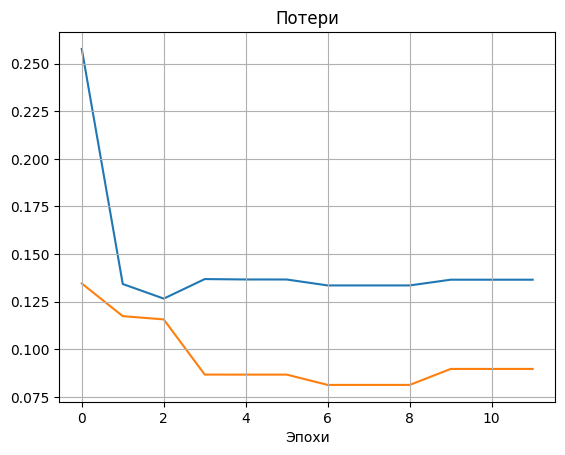

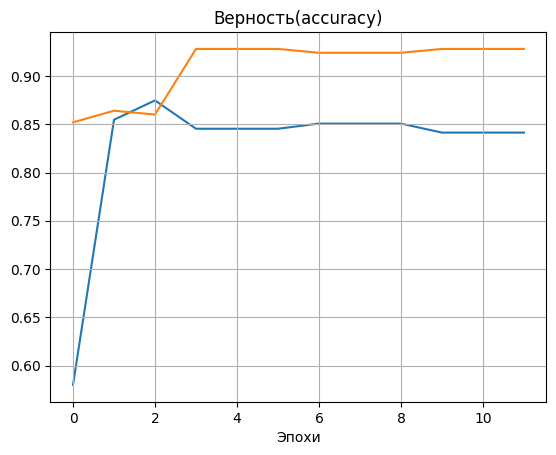

In [ ]:
classification = ClassificationImage()
start = time.time()
train_loss_log, train_acc_log, val_loss_log, val_acc_log, metrics_file_train, metrics_file_valid = classification.crossvalid(num_epoch=3)
print(f'{(time.time() - start)//60:.0f}мин {(time.time() - start)%50:.0f}с')
classification.plot_history(train_loss_log, val_loss_log)
classification.plot_history(train_acc_log, val_acc_log, 'Верность(accuracy)')

In [ ]:
classification.watch_dataframe(metrics_file_train, True)
classification.watch_dataframe(metrics_file_valid, True)

,№ эпохи,Файл,Предсказанный.класс,Верность(accuracy)предс. класса,Истинный класс,Верность(accuracy)истин. класса
0,0,2263.jpg,0,0.17792517,1,-0.062143635
1,0,2264.jpg,4,0.24645296,1,0.14957583
2,0,2265.jpg,2,0.34987673,1,0.17480604
3,0,2266.jpg,4,0.43055204,5,-0.14213055
4,0,2267.jpg,4,0.5348239,5,-0.6077835
5,0,2268.jpg,5,1.0841941,3,-1.1749078
8,0,2271.jpg,1,1.0185426,4,-0.44670525
9,0,2272.jpg,1,0.9010702,5,0.45627302
10,0,2273.jpg,1,1.7659023,4,-0.766125
11,0,2274.jpg,1,1.4730592,6,-2.2034452


,№ эпохи,Файл,Предсказанный.класс,Верность(accuracy)предс. класса,Истинный класс,Верность(accuracy)истин. класса
1,0,2139.jpg,5,0.59967333,6,-0.6699707
3,0,2141.jpg,1,0.70304567,6,-1.8579695
6,0,2144.jpg,5,-0.057586793,4,-0.21222603
7,0,2145.jpg,5,-0.1907152,4,-0.29379025
10,0,2148.jpg,5,0.41266525,7,-2.099564
26,0,2164.jpg,5,-0.31304044,7,-2.9817483
28,0,2166.jpg,5,0.37862167,6,-1.0984664
31,0,2169.jpg,1,-0.14645527,4,-0.7029724
33,0,2171.jpg,5,0.32415867,4,-0.06425764
35,0,2173.jpg,1,-0.32544306,5,-0.33449018


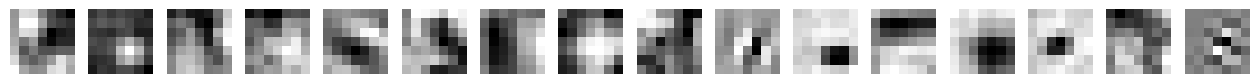

In [ ]:
classification.visual_filters()

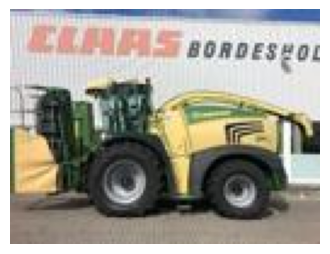

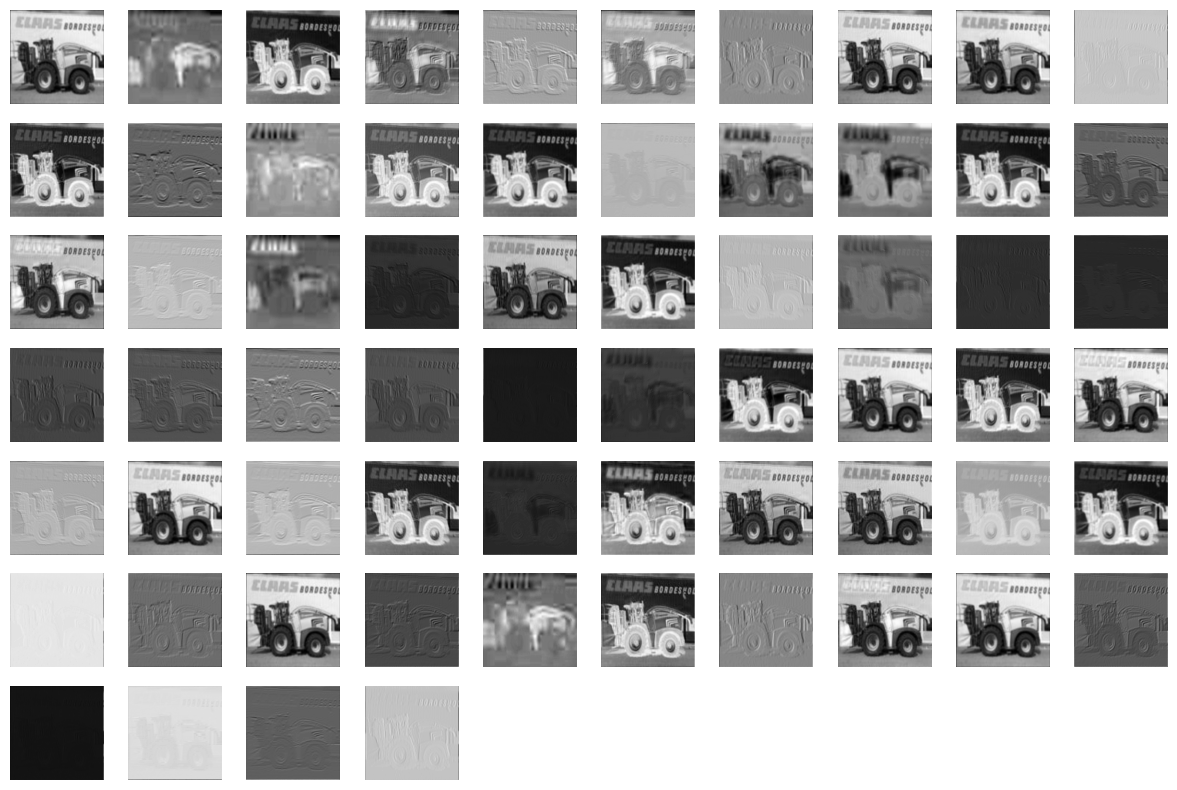

In [ ]:
classification.visual_maps()

Модель переводится в обычное состояние, при котором она не тренируется, тестируется и сохраняется в файл для дальнейшего использования. Здесь классицифируются следующие объекты:

0 - автокран

1 - легковой автомобиль

2 - экскаватор

3 - человек

4 - самосвал

5 - карьерный погрузчик

6 - каток

7 - бульдозер

100%|██████████| 428/428 [00:40<00:00, 10.57it/s]


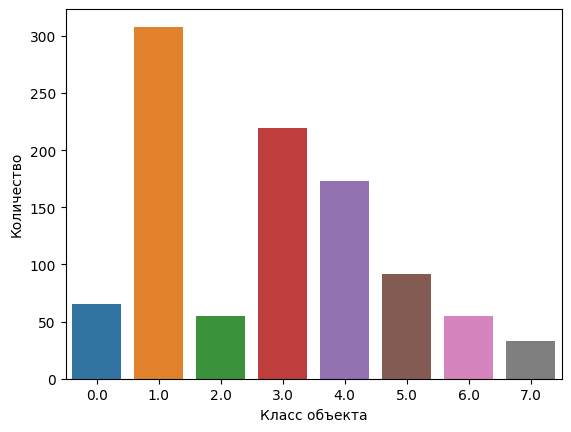

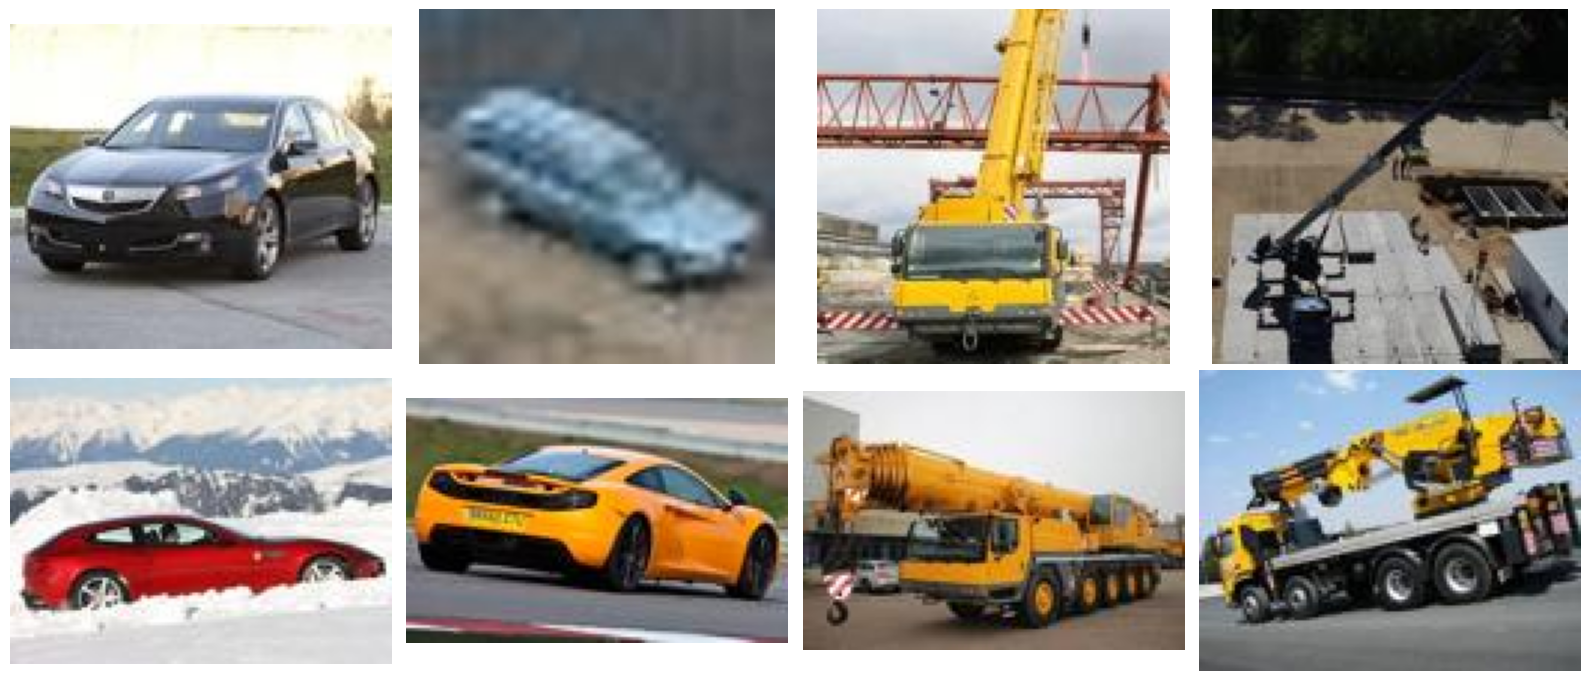

In [ ]:
classification.watch_img()
classification.evaluation_model()
classification.save_model("ImageClassifier.pt")